In [1]:
import duckdb
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

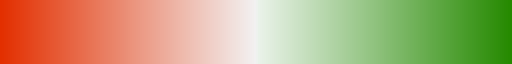

In [2]:
sns.set_style("whitegrid")
sns.set_palette("muted")
hm_w = 10
hm_h = 4
set_title = False
sns.set(font_scale = 1.8)
my_cmap = sns.diverging_palette(15, 125, s=100, l=50, as_cmap=True)
my_cmap

In [3]:
con = duckdb.connect()
grouping_cols = ['count', 'columns', 'col_width', 'category']

# Functions

In [4]:
def load_csv(con, csv_path, median_cols):
    q = "select "
    q += ", ".join(grouping_cols)
    q += ", " + ", ".join([f"median({c}) as {c}" for c in median_cols])
    q += f" from read_csv_auto('{csv_path}') "
    q += "group by " + ", ".join(grouping_cols)
    q += " order by " + ", ".join(grouping_cols)
    con.execute(q)
    return con.fetchdf()

In [5]:
def compute_relative_runtime(con, df, cat1, cat2, col):
    q = "select\n\tcast(log2(c1.count) as int) as row_count,"
    q += f"\n\tc1.columns,\n\tc1.col_width,\n\tc1.{col} as {cat1}_{col},\n\tc2.{col} as {cat2}_{col},"
    q += f"\n\tround(c1.{col} / c2.{col}, 2) as relative_runtime"
    q += f"\nfrom\n\tdf c1,\n\tdf c2"
    q += f"\nwhere\n\tc1.category = '{cat1}'\nand\tc2.category = '{cat2}'\nand\t"
    q += "\nand\t".join([f"c1.{c} = c2.{c}" for c in grouping_cols[:-1]])
    q += "\norder by\n\trow_count,\n\t"
    q += ",\n\t".join([f"c1.{c}" for c in grouping_cols[1:-1]])
    con.execute(q)
    return con.fetchdf()

In [6]:
def create_heatmap(df, columns, title, fname):
    fig, ax = plt.subplots(figsize=(hm_w, hm_h))
    g = sns.heatmap(df.pivot(columns[0], columns[1], columns[2]), linewidths=1, center=1, cmap=my_cmap, ax=ax, annot=True, robust=True, cbar=False)
    g.invert_yaxis()
    labels = ['$2^{' + item.get_text() + '}$' for item in ax.get_xticklabels()]
    ax.set_xticklabels(labels)
    if set_title:
        plt.title(f'Relative runtime of {title}')
    plt.savefig(f'figures/{fname}.eps', bbox_inches="tight")
    plt.show()

# Reordering

In [7]:
reorder_df = load_csv(con, 'results/reorder.csv', ['total', 'reorder', 'scatter', 'gather'])
con.execute("select category, sum(total) from reorder_df group by category")
con.fetchdf()

,category,sum(total)
0,col,2.051544e+10
1,row,2.792118e+10


In [8]:
reorder_total_df = compute_relative_runtime(con, reorder_df, 'col', 'row', 'total')
con.execute("select avg(relative_runtime), median(relative_runtime) from reorder_total_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,0.424063,0.375


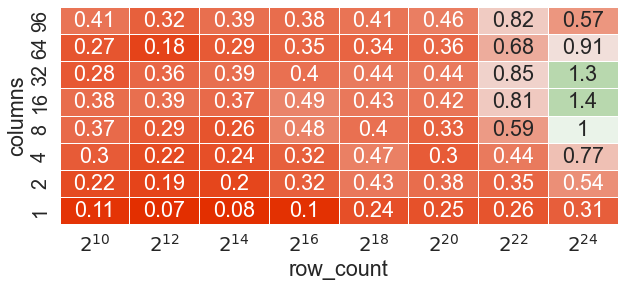

In [9]:
create_heatmap(reorder_total_df,
               ['columns', 'row_count', 'relative_runtime'],
               'payload reordering rows vs. columns (incl. scatter + gather)',
               'reorder_incl_sg')

In [10]:
reorder_only_df = compute_relative_runtime(con, reorder_df, 'col', 'row', 'reorder')
con.execute("select avg(relative_runtime), median(relative_runtime) from reorder_only_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,1.318906,1.23


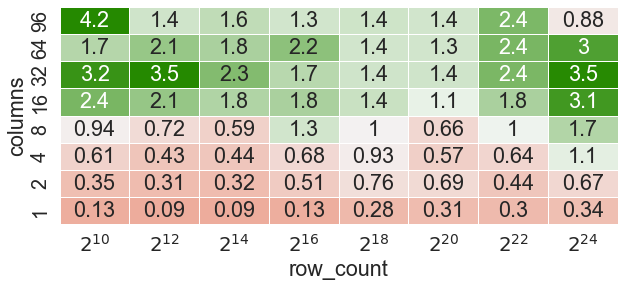

In [11]:
create_heatmap(reorder_only_df,
               ['columns', 'row_count', 'relative_runtime'],
               'payload reordering rows vs. columns (excl. scatter + gather)',
               'reorder_excl_sg')

In [12]:
con.execute("""
    select
        cast(log2(count) as int) as row_count,
        columns,
        col_width,
        reorder as "row reorder",
        round(cast(scatter + gather as double) / total, 2) as sg
    from
        reorder_df
    where
        category = 'row'
    order by
        row_count asc,
        columns asc
""")
reorder_percentage_df = con.fetchdf()
con.execute('select avg(sg), median(sg) from reorder_percentage_df')
con.fetchdf()

,avg(sg),median(sg)
0,0.551562,0.58


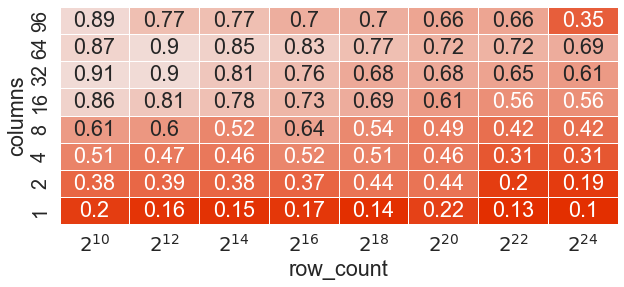

In [13]:
create_heatmap(reorder_percentage_df,
               ['columns', 'row_count', 'sg'],
               'scatter + gather as percentage of reorder runtime',
               'reorder_sg_percentage')

# Comparator

In [14]:
comparator_df = load_csv(con, 'results/comparator.csv', ['total', 'sort', 'scatter', 'gather'])
con.execute("select category, sum(total) from comparator_df group by category")
con.fetchdf()

,category,sum(total)
0,col,1.330241e+12
1,col_ss,1.821351e+11
2,row_branched,1.822759e+11
3,row_branchless,1.230633e+11


In [15]:
comparator_col_iter_df = compute_relative_runtime(con, comparator_df, 'col', 'col_ss', 'total')
con.execute("select avg(relative_runtime), median(relative_runtime) from comparator_col_iter_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,3.0815,3.05


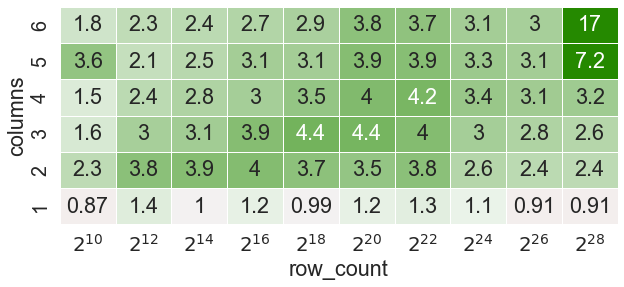

In [16]:
create_heatmap(comparator_col_iter_df,
               ['columns', 'row_count', 'relative_runtime'],
               'columnar_iterative vs. columnar_all (pdqsort)',
               'comparator_col_iter')

In [17]:
comparator_row_key_df = compute_relative_runtime(con, comparator_df, 'col_ss', 'row_branched', 'total')
con.execute("select avg(relative_runtime), median(relative_runtime) from comparator_row_key_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,0.6755,0.59


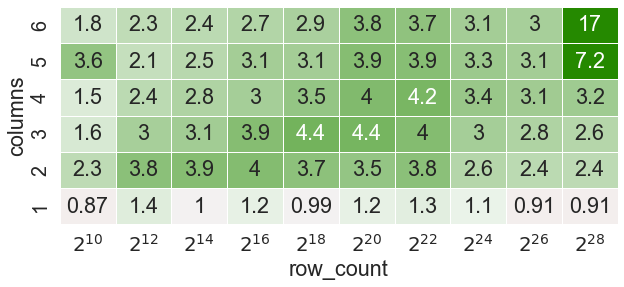

In [18]:
create_heatmap(comparator_col_iter_df,
               ['columns', 'row_count', 'relative_runtime'],
               'row_key vs. columnar_iterative (pdqsort)',
               'comparator_row_key')

In [19]:
comparator_norm_key_df = compute_relative_runtime(con, comparator_df, 'col_ss', 'row_branchless', 'total')
con.execute("select avg(relative_runtime), median(relative_runtime) from comparator_norm_key_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,1.035667,0.89


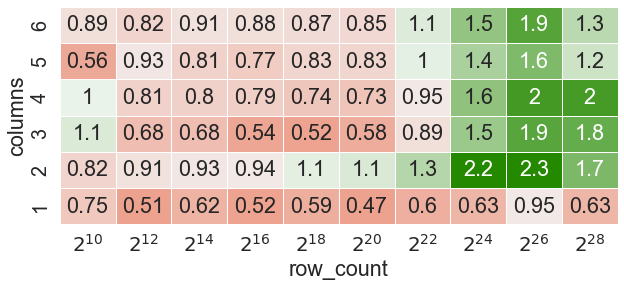

In [20]:
create_heatmap(comparator_norm_key_df,
               ['columns', 'row_count', 'relative_runtime'],
               'normalized_key vs. columnar_iterative (pdqsort)',
               'comparator_norm_key')

# Sort

In [21]:
sort_df = load_csv(con, 'results/sort.csv', ['total', 'sort', 'scatter', 'gather'])
con.execute("select category, sum(sort) from sort_df group by category")
con.fetchdf()

,category,sum(sort)
0,pdq_dynamic,2.382845e+09
1,pdq_static,1.243290e+09
2,radix,2.026616e+09


In [22]:
sort_static_radix_df = compute_relative_runtime(con, sort_df, 'pdq_static', 'radix', 'sort')
con.execute("select avg(relative_runtime), median(relative_runtime) from sort_static_radix_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,0.536279,0.51


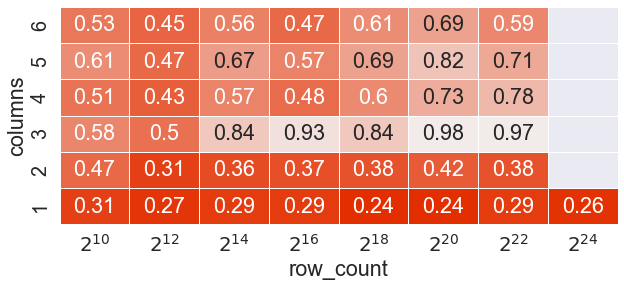

In [23]:
create_heatmap(sort_static_radix_df,
               ['columns', 'row_count', 'relative_runtime'],
               'pdq_static vs. radix',
               'sort_static')

In [24]:
sort_dynamic_radix_df = compute_relative_runtime(con, sort_df, 'pdq_dynamic', 'radix', 'sort')
con.execute("select avg(relative_runtime), median(relative_runtime) from sort_dynamic_radix_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,1.269535,1.23


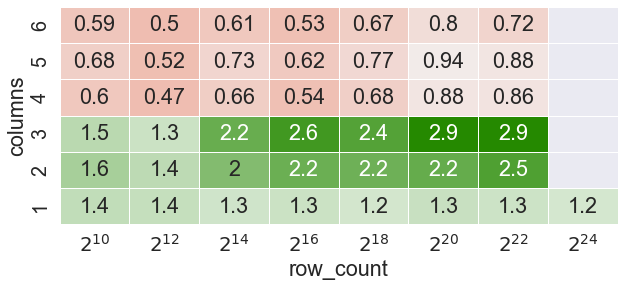

In [25]:
create_heatmap(sort_dynamic_radix_df,
               ['columns', 'row_count', 'relative_runtime'],
               'pdq_dynamic vs. radix',
               'sort_dynamic')

# Merge

In [26]:
merge_df = load_csv(con, 'results/merge.csv', ['total'])
con.execute("select category, sum(total) from merge_df group by category")
con.fetchdf()

,category,sum(total)
0,col,8.309234e+09
1,row,6.034327e+09


In [27]:
merge_row_col_df = compute_relative_runtime(con, merge_df, 'col', 'row', 'total')
con.execute("select avg(relative_runtime), median(relative_runtime) from merge_row_col_df")
con.fetchdf()

,avg(relative_runtime),median(relative_runtime)
0,1.273281,1.01


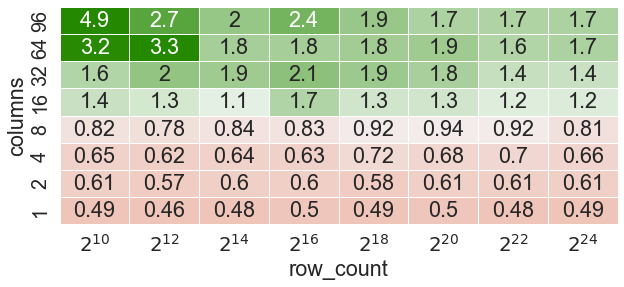

In [28]:
create_heatmap(merge_row_col_df,
               ['columns', 'row_count', 'relative_runtime'],
               'merging rows vs. merging columns',
               'merge')

# Trace

In [29]:
# TODO

# Templating ...

In [30]:
for i in range(2, 20):
    print('struct NormalizedKey' + str(i * 4) + ' {')
    for j in range(i):
        print('\tuint32_t i' + str(j) + ';')
    print('};\n')

struct NormalizedKey8 {
	uint32_t i0;
	uint32_t i1;
};

struct NormalizedKey12 {
	uint32_t i0;
	uint32_t i1;
	uint32_t i2;
};

struct NormalizedKey16 {
	uint32_t i0;
	uint32_t i1;
	uint32_t i2;
	uint32_t i3;
};

struct NormalizedKey20 {
	uint32_t i0;
	uint32_t i1;
	uint32_t i2;
	uint32_t i3;
	uint32_t i4;
};

struct NormalizedKey24 {
	uint32_t i0;
	uint32_t i1;
	uint32_t i2;
	uint32_t i3;
	uint32_t i4;
	uint32_t i5;
};

struct NormalizedKey28 {
	uint32_t i0;
	uint32_t i1;
	uint32_t i2;
	uint32_t i3;
	uint32_t i4;
	uint32_t i5;
	uint32_t i6;
};

struct NormalizedKey32 {
	uint32_t i0;
	uint32_t i1;
	uint32_t i2;
	uint32_t i3;
	uint32_t i4;
	uint32_t i5;
	uint32_t i6;
	uint32_t i7;
};

struct NormalizedKey36 {
	uint32_t i0;
	uint32_t i1;
	uint32_t i2;
	uint32_t i3;
	uint32_t i4;
	uint32_t i5;
	uint32_t i6;
	uint32_t i7;
	uint32_t i8;
};

struct NormalizedKey40 {
	uint32_t i0;
	uint32_t i1;
	uint32_t i2;
	uint32_t i3;
	uint32_t i4;
	uint32_t i5;
	uint32_t i6;
	uint32_t i7;
	uint32_t i8;
	u

In [31]:
print('void PDQSort(data_ptr_t ptr, idx_t count, idx_t row_width, idx_t comp_width) {')
print('\tswitch (row_width) {')
for i in range(2, 20):
    print(f'\tcase {i * 4}:')
    print(f'\t\treturn PDQSort<NormalizedKey{i * 4}>(ptr, count, comp_width);')
print('\t}')
print('}')

void PDQSort(data_ptr_t ptr, idx_t count, idx_t row_width, idx_t comp_width) {
	switch (row_width) {
	case 8:
		return PDQSort<NormalizedKey8>(ptr, count, comp_width);
	case 12:
		return PDQSort<NormalizedKey12>(ptr, count, comp_width);
	case 16:
		return PDQSort<NormalizedKey16>(ptr, count, comp_width);
	case 20:
		return PDQSort<NormalizedKey20>(ptr, count, comp_width);
	case 24:
		return PDQSort<NormalizedKey24>(ptr, count, comp_width);
	case 28:
		return PDQSort<NormalizedKey28>(ptr, count, comp_width);
	case 32:
		return PDQSort<NormalizedKey32>(ptr, count, comp_width);
	case 36:
		return PDQSort<NormalizedKey36>(ptr, count, comp_width);
	case 40:
		return PDQSort<NormalizedKey40>(ptr, count, comp_width);
	case 44:
		return PDQSort<NormalizedKey44>(ptr, count, comp_width);
	case 48:
		return PDQSort<NormalizedKey48>(ptr, count, comp_width);
	case 52:
		return PDQSort<NormalizedKey52>(ptr, count, comp_width);
	case 56:
		return PDQSort<NormalizedKey56>(ptr, count, comp_width);
	cas

In [32]:
print('template <class T, idx_t col_offset>')
print('void PDQSortSwitchCompWidth(data_ptr_t ptr, idx_t count, idx_t comp_width) {')
print('\tswitch (comp_width) {')
for i in range(0, 37):
    print(f'\tcase {i}:')
    print(f'\t\treturn PDQSort<T, col_offset, {i}>(ptr, count);')
print('\t}')
print('}')

template <class T, idx_t col_offset>
void PDQSortSwitchCompWidth(data_ptr_t ptr, idx_t count, idx_t comp_width) {
	switch (comp_width) {
	case 0:
		return PDQSort<T, col_offset, 0>(ptr, count);
	case 1:
		return PDQSort<T, col_offset, 1>(ptr, count);
	case 2:
		return PDQSort<T, col_offset, 2>(ptr, count);
	case 3:
		return PDQSort<T, col_offset, 3>(ptr, count);
	case 4:
		return PDQSort<T, col_offset, 4>(ptr, count);
	case 5:
		return PDQSort<T, col_offset, 5>(ptr, count);
	case 6:
		return PDQSort<T, col_offset, 6>(ptr, count);
	case 7:
		return PDQSort<T, col_offset, 7>(ptr, count);
	case 8:
		return PDQSort<T, col_offset, 8>(ptr, count);
	case 9:
		return PDQSort<T, col_offset, 9>(ptr, count);
	case 10:
		return PDQSort<T, col_offset, 10>(ptr, count);
	case 11:
		return PDQSort<T, col_offset, 11>(ptr, count);
	case 12:
		return PDQSort<T, col_offset, 12>(ptr, count);
	case 13:
		return PDQSort<T, col_offset, 13>(ptr, count);
	case 14:
		return PDQSort<T, col_offset, 14>(ptr, count)

In [33]:
print('template <class T>')
print('void PDQSortSwitchColOffset(data_ptr_t ptr, idx_t count, idx_t col_offset, idx_t comp_width) {')
print('\tswitch (col_offset) {')
for i in range(0, 36):
    print(f'\tcase {i}:')
    print(f'\t\treturn PDQSortSwitchCompWidth<T, {i}>(ptr, count, comp_width);')
print('\t}')
print('}')

template <class T>
void PDQSortSwitchColOffset(data_ptr_t ptr, idx_t count, idx_t col_offset, idx_t comp_width) {
	switch (col_offset) {
	case 0:
		return PDQSortSwitchCompWidth<T, 0>(ptr, count, comp_width);
	case 1:
		return PDQSortSwitchCompWidth<T, 1>(ptr, count, comp_width);
	case 2:
		return PDQSortSwitchCompWidth<T, 2>(ptr, count, comp_width);
	case 3:
		return PDQSortSwitchCompWidth<T, 3>(ptr, count, comp_width);
	case 4:
		return PDQSortSwitchCompWidth<T, 4>(ptr, count, comp_width);
	case 5:
		return PDQSortSwitchCompWidth<T, 5>(ptr, count, comp_width);
	case 6:
		return PDQSortSwitchCompWidth<T, 6>(ptr, count, comp_width);
	case 7:
		return PDQSortSwitchCompWidth<T, 7>(ptr, count, comp_width);
	case 8:
		return PDQSortSwitchCompWidth<T, 8>(ptr, count, comp_width);
	case 9:
		return PDQSortSwitchCompWidth<T, 9>(ptr, count, comp_width);
	case 10:
		return PDQSortSwitchCompWidth<T, 10>(ptr, count, comp_width);
	case 11:
		return PDQSortSwitchCompWidth<T, 11>(ptr, count, comp_wid

In [34]:
print('void PDQSortSwitchRowWidth(data_ptr_t ptr, idx_t count, idx_t row_width, idx_t col_offset, idx_t comp_width) {')
print('\tswitch (row_width) {')
for i in range(2, 9):
    print(f'\tcase {i * 4}:')
    print(f'\t\treturn PDQSortSwitchColOffset<NormalizedKey{i * 4}>(ptr, count, col_offset, comp_width);')
print('\t}')
print('}')

void PDQSortSwitchRowWidth(data_ptr_t ptr, idx_t count, idx_t row_width, idx_t col_offset, idx_t comp_width) {
	switch (row_width) {
	case 8:
		return PDQSortSwitchColOffset<NormalizedKey8>(ptr, count, col_offset, comp_width);
	case 12:
		return PDQSortSwitchColOffset<NormalizedKey12>(ptr, count, col_offset, comp_width);
	case 16:
		return PDQSortSwitchColOffset<NormalizedKey16>(ptr, count, col_offset, comp_width);
	case 20:
		return PDQSortSwitchColOffset<NormalizedKey20>(ptr, count, col_offset, comp_width);
	case 24:
		return PDQSortSwitchColOffset<NormalizedKey24>(ptr, count, col_offset, comp_width);
	case 28:
		return PDQSortSwitchColOffset<NormalizedKey28>(ptr, count, col_offset, comp_width);
	case 32:
		return PDQSortSwitchColOffset<NormalizedKey32>(ptr, count, col_offset, comp_width);
	}
}


In [35]:
n_structs = (64 - 16)/8
n_offsets = len(range(0, 60))
n_comp_widths = len(range(1, 61))
n_structs * n_offsets * n_comp_widths

21600.0